## Imports

In [1]:
import os, torch, torchvision, time, copy, pickle
from skimage import transform
from __future__ import print_function, division
import torch.nn as nn, torch.optim as optim, matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sn
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms, utils
from PIL import Image
from sklearn.metrics import confusion_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MM_training = 1


with open('/kaggle/input/upmc-food-101-text-part/objs.pkl', 'rb') as f: 
    classes = pickle.load(f)
Num_class = len(classes)
print('Classes:', classes, '\nNumber of Classes:', Num_class)


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.yticks([])  
    plt.xticks([])  
    plt.imshow(inp)
    plt.savefig('Augmented_ultrasound.pdf', bbox_inches = 'tight') 
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 

## Links

In [2]:
Text_Model_link = '/kaggle/input/upmc-food-101-text-part/RNN_text_model.pt'
Texts_csv = {
    'train': '/kaggle/input/upmc-food-101-text-part/train.csv',
    'valid': '/kaggle/input/upmc-food-101-text-part/valid.csv',
    'test' : '/kaggle/input/upmc-food-101-text-part/test.csv'
}

Image_folders = {
    'root' : '/kaggle/input/upmcfood101/images',
    'train': '/kaggle/input/upmcfood101/images/train',
    'valid': '/kaggle/input/upmcfood101/images/train',
    'test' : '/kaggle/input/upmcfood101/images/test'
}

In [3]:
class MultimodalDataset(Dataset):
    # Modified from: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    def __init__(self, csv_file, root_dir, transform = None):
        self.csv_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        labels = int(self.csv_frame.iloc[idx, 2])
        
        img_link = self.root_dir +'/' + classes[labels] +'/' + self.csv_frame.iloc[idx, 0]
        image = Image.open(img_link)
        
        other_inputs = torch.from_numpy(np.asarray(self.csv_frame.iloc[idx, 3:104].tolist()))
        sample = {'image': image, 'information': other_inputs,'labels': labels}

        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

## MM Transforms

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((244,244)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

class MM_transform(object):
    def __init__(self, phase):
        assert isinstance(phase,(str))
        self.phase = phase
        
    def __call__(self, sample):
        image, information, labels = sample['image'],sample['information'], sample['labels']
        #image, labels = sample['image'], sample['labels']
        trnsfrm = data_transforms[self.phase]
        image = trnsfrm(image)
        
        return {'image': image, 'information': information, 'labels': labels}
        #return {'image': image, 'labels': labels}

## Dataloader with Multimodal Transform

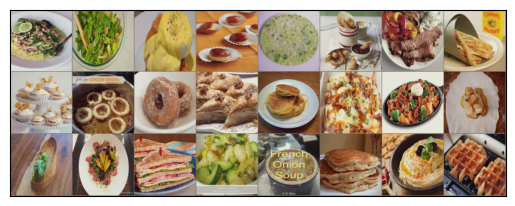

In [5]:
def dataset_phase(phase):
    return MultimodalDataset(csv_file = Texts_csv[phase], root_dir = Image_folders[phase],
                        transform = MM_transform(phase))

def dataloader_phase(phase):
    return DataLoader(dataset[phase], batch_size = 24, shuffle=True, num_workers=0)
    
dataset = {x: dataset_phase(x) for x in ['train', 'valid', 'test']}
dataloaders = {x: dataloader_phase(x) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'valid', 'test']}
               
sample_batch = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(sample_batch['image'])
imshow(out)

In [6]:
class NullNet(nn.Module): 
    def __init__(self):
        super(NullNet, self).__init__()
    def forward(self, x):
        return x
    
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = NullNet()

#model_ft = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=Num_class)
#num_ftrs = model_ft.head.in_features
#model_ft.head = NullNet()

model_fc = nn.Linear(num_ftrs, Num_class)
if MM_training:
    model_fc = nn.Linear(num_ftrs + Num_class, Num_class).to(torch.float64)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


In [7]:
def train_model_MM(model, model_fc, criterion, optimizer, scheduler, num_epochs=25, MM_training=1):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid', 'test']:
            '''
            Test when a better validation result is found
            '''
            if test_token ==0 and phase == 'test':
                continue
            test_token =0
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample_batch in dataloaders[phase]:
                inputs = sample_batch['image'].to(device)
                labels = sample_batch['labels'].to(device)
                params = sample_batch['information'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    features = model(inputs)
                    if MM_training:
                        features = torch.cat((features, params), 1)
                    outputs = model_fc(features)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model_fc.state_dict())
                test_token =1

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model_fc.load_state_dict(best_model_wts)
    return model_fc

In [8]:
optimizer_fc = optim.SGD(model_fc.parameters(), lr=0.0005, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_fc, step_size=7, gamma=0.1)
model_ft = model_ft.to(device)
model_fc = model_fc.to(device)
criterion = nn.CrossEntropyLoss()

model_fc = train_model_MM(model_ft, model_fc, criterion, optimizer_fc, exp_lr_scheduler, num_epochs=5, MM_training=MM_training)

Epoch 0/4
----------
train Loss: 0.6786 Acc: 0.8612
valid Loss: 0.4584 Acc: 0.9019
test Loss: 0.8394 Acc: 0.8401

Epoch 1/4
----------
train Loss: 0.4376 Acc: 0.9050
valid Loss: 0.3888 Acc: 0.9154
test Loss: 0.8075 Acc: 0.8476

Epoch 2/4
----------
train Loss: 0.3941 Acc: 0.9145
valid Loss: 0.3615 Acc: 0.9197
test Loss: 0.8075 Acc: 0.8498

Epoch 3/4
----------
train Loss: 0.3694 Acc: 0.9182
valid Loss: 0.3361 Acc: 0.9247
test Loss: 0.7915 Acc: 0.8531

Epoch 4/4
----------
train Loss: 0.3499 Acc: 0.9234
valid Loss: 0.3261 Acc: 0.9273
test Loss: 0.7887 Acc: 0.8561

Training complete in 103m 24s
Best val Acc: 0.927321
